In [1]:
import numpy as np
import os
import pickle
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [3]:
gt_trees = load_jets("data", "ginkgo_10000_jets_no_cuts_lambda_21_pt_min_36_jetp_400_with_perm")  # My test file

## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
arr = np.arange(len(gt_trees))
good_indices = arr[((arr != 4835) & (arr != 9024))]
gt_trees = (np.array(gt_trees)[good_indices]).tolist()

## Load trellis grid results

In [4]:
time.time()

1624894514.1433022

In [5]:
def get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                 Njets=10000,
                                 likelihood="marginal",
                                 datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
        
    likelihood_surface = np.zeros((Njets, n_lambda))

    for i in range(n_lambda):
        model_params = {"delta_min": 36.0, "lam": lambda_vals[i]}

        in_filename = os.path.join(datadir, "trellis_1000_jets_1D_lambda_{:n}_ptcut_{:n}_{}_with_perm.pkl".format(
            int(lambda_vals[i])*1000,
            int(36.0),
            i))
        with open(in_filename, "rb") as fd:
            results = pickle.load(fd, encoding='latin-1')

        ## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
        #myresults = np.array(results[key])
        #arr = np.arange(len(myresults))
        #good_indices = ((arr != 4835) & (arr != 9024))
        #myresults = myresults[good_indices]

        for k in range(Njets):
            likelihood_surface[k,i] = results[key][k]
                
    return likelihood_surface

In [23]:
seed = int(time.time()*1000) % 2**32

### THERE ARE TWO BAD JETS WITH INDICES (starting from 0)
- 4835
- 9024

In [24]:
arr = np.arange(10000)
((arr != 4835) & (arr != 9024)).sum()

9998

## Look at Results

In [25]:
n_lambda = 150
N_jets = 10000

lambda_min = 1.6
lambda_max = 2.75

lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)

### Get truth results

In [26]:
truth_bin = None
        
for ix, x in enumerate(lambda_vals >= 2.1):
    if x.item() is True:
        truth_bin = ix-1
        break
        
print(truth_bin)

64


In [27]:
lambda_vals[truth_bin]

2.0939597315436242

# Look at fit results across several minibatches

In [28]:
n_lambda = 150
N_jets = 10000

lambda_min = 1.6
lambda_max = 2.75

lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)

### Load all of the likelihood surfaces

In [29]:
likelihood_surface_array = get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                                        Njets=1000,
                                                        likelihood="marginal")
"""## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
arr = np.arange(likelihood_surface_array.shape[0])
good_indices = arr[((arr != 4835) & (arr != 9024))]
likelihood_surface_array = likelihood_surface_array[good_indices]"""

'## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET\narr = np.arange(likelihood_surface_array.shape[0])\ngood_indices = arr[((arr != 4835) & (arr != 9024))]\nlikelihood_surface_array = likelihood_surface_array[good_indices]'

In [128]:
lambda_dist = []
chi2_dist = []
batch_mle_coords = []

arr = np.arange(likelihood_surface_array.shape[0])

for seed in range(10):
    np.random.seed(seed)
    
    random_indices = np.random.choice(arr, 100, replace=False)
    
    batch_likelihood_surface = np.sum(likelihood_surface_array[random_indices], axis=0)
    Z = -2*(batch_likelihood_surface-batch_likelihood_surface.max())
    
    mle_coords = np.unravel_index(np.argmax(batch_likelihood_surface[~np.isnan(batch_likelihood_surface)], axis=None),
                                  batch_likelihood_surface.shape)[0]
    
    batch_mle_coords.append(mle_coords)
    chi2_dist.append(Z[truth_bin])
    lambda_dist.append(lambda_vals[mle_coords])
        
lambda_dist = np.array(lambda_dist)
chi2_dist = np.array(chi2_dist)

In [129]:
print(chi2_dist)

[ 2.12918821  0.41898745 12.28121752  1.63691624  9.16313591  1.63784041
  1.67713489  7.01737109  2.08003367  6.18848556]


In [122]:
lambda_min_bin = 0
lambda_max_bin = 0

for ix, x in enumerate(lambda_vals == np.min(lambda_dist[lambda_dist != None])):
    if x.item() is True:
        lambda_min_bin = ix
        break
        
for ix, x in enumerate(lambda_vals == np.max(lambda_dist[lambda_dist != None])):
    if x.item() is True:
        lambda_max_bin = ix
        break
        
lambda_hist_bins = lambda_vals[lambda_min_bin:lambda_max_bin+2]

Text(0.5, 1.0, 'Distribution of Parameter MLEs')

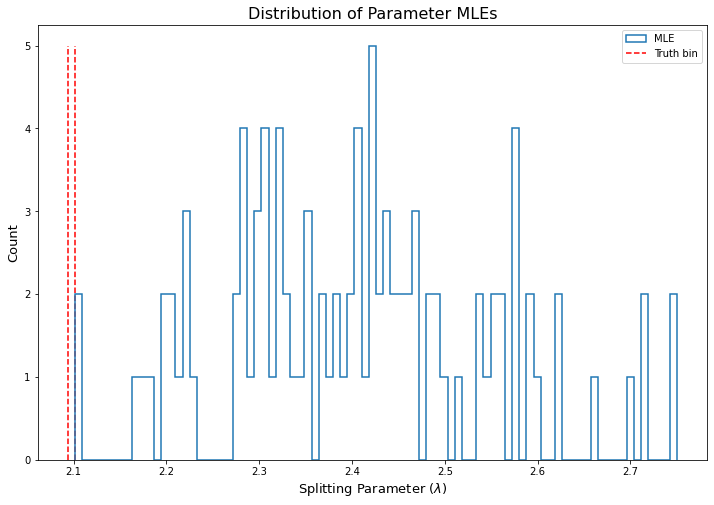

In [123]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12,8)

hist1 = ax1.hist(lambda_dist[lambda_dist != None],
                 bins=lambda_hist_bins,
                 histtype="step", linewidth=1.5, label="MLE")

ax1.vlines(lambda_vals[truth_bin], ymin=0, ymax=np.max(hist1[0]), colors="red", linestyle="dashed",
           linewidth=1.5, label="Truth bin")
ax1.vlines(lambda_vals[truth_bin+1], ymin=0, ymax=np.max(hist1[0]), colors="red", linestyle="dashed", linewidth=1.5)

ax1.legend()

ax1.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax1.set_ylabel("Count", size=13)
ax1.set_title("Distribution of Parameter MLEs", size=16)
#ax1.set_title("Distribution of Jet Likelihoods", size=15)

In [125]:
chi2_dist

array([2.12918821e+00, 4.18987447e-01, 1.22812175e+01, 1.63691624e+00,
       9.16313591e+00, 1.63784041e+00, 1.67713489e+00, 7.01737109e+00,
       2.08003367e+00, 6.18848556e+00, 1.25457867e-03, 6.85845177e+00,
       2.02521811e+00, 3.42687051e+00, 1.15140860e+00, 3.02319635e+00,
       4.71114766e+00, 7.36835663e+00, 5.25431534e+00, 3.32410549e+00,
       4.20027428e+00, 1.27953095e+00, 2.28919868e+00, 2.63423567e+00,
       1.40730280e+00, 1.08319445e+00, 4.29662144e+00, 2.99618485e+00,
       2.69751477e+00, 5.87942588e+00, 1.21286151e+01, 1.82073224e+00,
       2.33375188e+00, 2.98375617e+00, 2.54400689e-01, 1.39842782e+00,
       3.24725928e+00, 1.39630522e+00, 3.26947420e+00, 1.41501364e+00,
       3.67036743e+00, 3.90139345e+00, 3.63583710e+00, 6.53617567e+00,
       2.14369694e+00, 1.27928559e+00, 2.71926037e-03, 1.12745952e+01,
       4.74428222e+00, 3.30410828e+00, 3.39485708e+00, 5.13357449e-01,
       3.17112314e+00, 8.26938242e+00, 1.72925748e+00, 1.07617800e+00,
      

Text(0.5, 1.0, 'Distribution of -2log (L(truth) / L(MLE)) for the Batch MLEs')

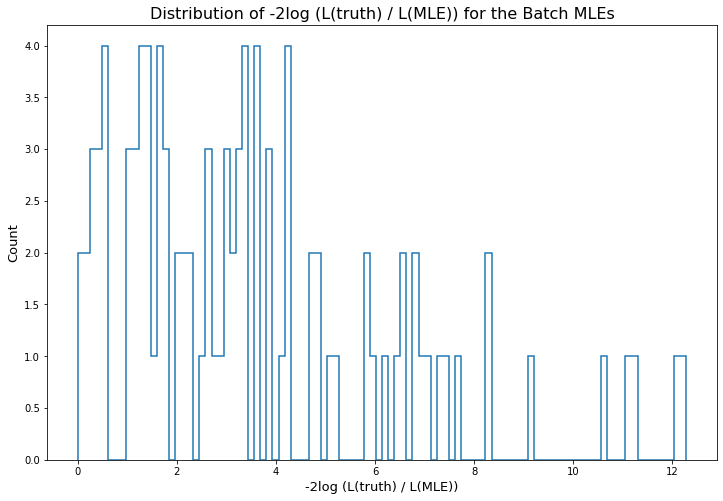

In [127]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12,8)

hist1 = ax1.hist(chi2_dist[chi2_dist != None],
                 bins=100,
                 histtype="step", linewidth=1.5)

ax1.set_xlabel("-2log (L(truth) / L(MLE))", size=13)
ax1.set_ylabel("Count", size=13)
ax1.set_title("Distribution of -2log (L(truth) / L(MLE)) for the Batch MLEs", size=16)
#ax1.set_title("Distribution of Jet Likelihoods", size=15)

In [107]:
np.var([x for x in lambda_dist if x is not None])

0.02399023101436872

In [108]:
total_likelihood_surface = np.sum(likelihood_surface_array, axis=0)

In [109]:
mle_coords = np.unravel_index(np.argmax(total_likelihood_surface[~np.isnan(total_likelihood_surface)], axis=None),
                                  total_likelihood_surface.shape)[0]
mle_coords

107

In [110]:
Z = -2*(total_likelihood_surface-total_likelihood_surface.max())

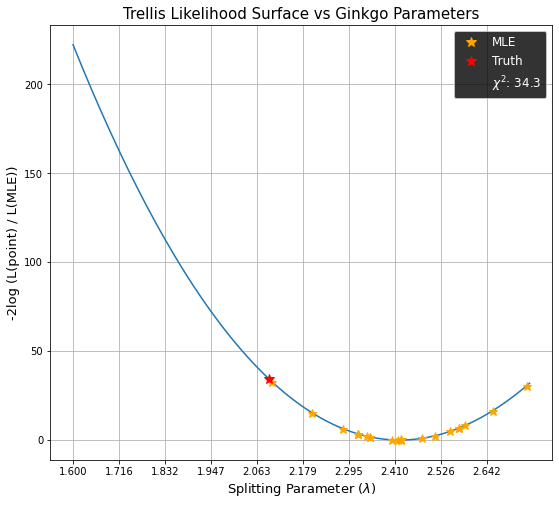

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

#chi2_marginal = Z[truth_bin]

ax.plot(lambda_vals, Z)
ax.plot(lambda_vals[mle_coords], Z[mle_coords], '*', color="orange", label="MLE", markersize=10)
for coords in batch_mle_coords:
    ax.plot(lambda_vals[coords], Z[coords], "*", color="orange", markersize=9)
ax.plot(lambda_vals[truth_bin], Z[truth_bin], '*', label="Truth", markersize=10, color="red")
ax.plot([], [], ' ', label="$\chi^2$: {:.1f}".format(chi2_marginal))


ax.legend(labelcolor="white", facecolor="black", fontsize="large")
ax.grid()

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
ax.set_xticks(lambda_vals[::15]);

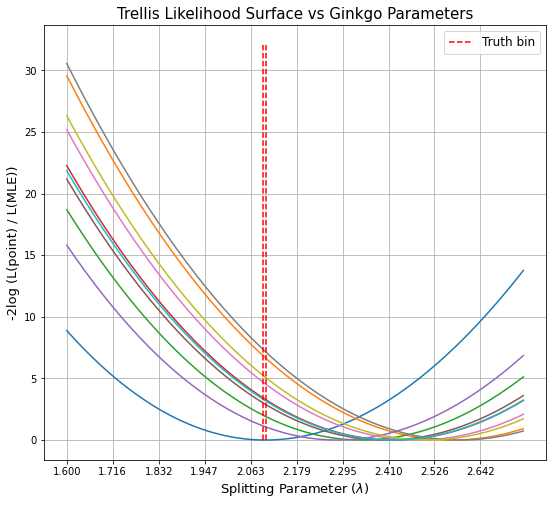

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

arr = np.arange(likelihood_surface_array.shape[0])

for seed in range(10, 20):
    np.random.seed(seed)

    random_indices = np.random.choice(arr, 100, replace=False)

    batch_likelihood_surface = np.sum(likelihood_surface_array[random_indices], axis=0)
    Z = -2*(batch_likelihood_surface-batch_likelihood_surface.max())

    ax.plot(lambda_vals, Z)
    
y_min, y_max = ax.get_ylim()
    
ax.vlines(lambda_vals[truth_bin], ymin=0, ymax=y_max, colors="red", linestyle="dashed",
           linewidth=1.5, label="Truth bin", zorder=1e4)
ax.vlines(lambda_vals[truth_bin+1], ymin=0, ymax=y_max, colors="red", linestyle="dashed", linewidth=1.5, zorder=1e4)

ax.grid()
ax.legend(fontsize="large")

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
ax.set_xticks(lambda_vals[::15]);

## Look at the distribution of leaves

In [39]:
trellis_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}".format(
    int(lambda_vals[mle_coords])*1000,
    int(36.0),
    mle_coords))

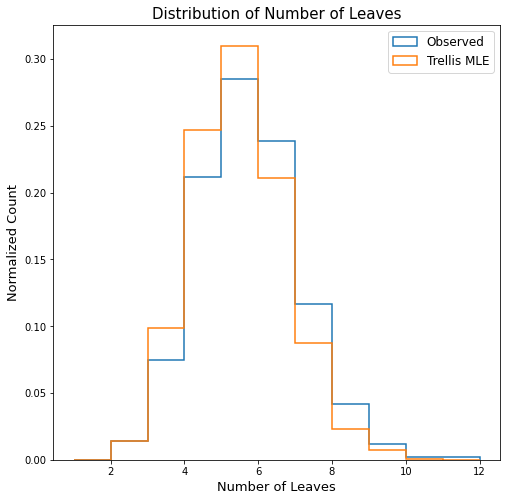

In [40]:
truth_num_leaves = [len(x["leaves"]) for x in gt_trees[:1000]]
trellis_num_leaves = [len(x["leaves"]) for x in trellis_mle_jets]

#mle_num_leaves = [len(x["leaves"]) for x in mle_gt_trees]
#print(np.min(mle_num_leaves), np.max(mle_num_leaves))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

ax.hist(truth_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5, density=True, label="Observed")
ax.hist(trellis_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5,  density=True, label="Trellis MLE")

ax.set_xlabel("Number of Leaves", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Number of Leaves", size=15)
ax.legend(fontsize="large")